# 1. Setup



## 1.1 Basic package setup

Note: Cell below identifies which GPU you have access to and how much memory is available

In [ ]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 26.3 GB  |     Proc size: 111.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn # Base class for all neural network modules
tqdm.pandas(desc="Apply progress")
from tensorflow import nn



/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
#mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 GPU setup

Set and identify GPU we can use for training

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.3. Installing the Hugging Face Library


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 12.1MB/s 
     |████████████████████████████████| 3.2MB 57.9MB/s 
     |████████████████████████████████| 870kB 64.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=3d3026e17530fee5146f68a2db2460eef384329a59c3f31ba9f1c7c018fe11b2
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


# 2. Import Data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/w266: NLP Project/data/3days_by_hour/train.csv')
df_val = pd.read_csv('/content/drive/MyDrive/w266: NLP Project/data/3days_by_hour/val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/w266: NLP Project/data/3days_by_hour/test.csv')
print('Training dataset shape: {}'.format(df_train.shape))

Training dataset shape: (52363, 3)


# 3. Tokenization and Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)

Loading BERT tokenizer...


Testing tokenization

In [ ]:
import textwrap

sample_note = df_train.iloc[1]['TEXT']

# Print the original sentence.
print('Original: ', textwrap.fill(sample_note, 80))

# Print the sentence split into tokens.
tokenized_note = tokenizer.tokenize(sample_note)
print('Tokenized: ', tokenized_note)

# Print the sentence mapped to token ids.
token_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sample_note))
print('Token IDs: ', token_ids)

Original:  t.i.d. percocet 5 one to two tablets p.o. q.6h. p.r.n. aspirin 81 mg p.o. q.d. ,
md dictated by: medquist36 d: 23:01 t: 18:17 job#:
Tokenized:  ['t', '.', 'i', '.', 'd', '.', 'per', '##co', '##ce', '##t', '5', 'one', 'to', 'two', 'tablets', 'p', '.', 'o', '.', 'q', '.', '6', '##h', '.', 'p', '.', 'r', '.', 'n', '.', 'as', '##pi', '##rin', '81', 'mg', 'p', '.', 'o', '.', 'q', '.', 'd', '.', ',', 'm', '##d', 'dictated', 'by', ':', 'me', '##d', '##quist', '##36', 'd', ':', '23', ':', '01', 't', ':', '18', ':', '17', 'job', '#', ':']
Token IDs:  [189, 119, 178, 119, 173, 119, 1679, 2528, 2093, 1204, 126, 1141, 1106, 1160, 20159, 185, 119, 184, 119, 186, 119, 127, 1324, 119, 185, 119, 187, 119, 183, 119, 1112, 8508, 4854, 5615, 17713, 185, 119, 184, 119, 186, 119, 173, 119, 117, 182, 1181, 26754, 1118, 131, 1143, 1181, 19854, 22997, 173, 131, 1695, 131, 5187, 189, 131, 1407, 131, 1542, 2261, 108, 131]


##3.1 Notes to token IDs

In [ ]:
def encode_notes(df):
  #prepare a temporary list to hold the arrays of encoded notes
  temp_list = []

  # `encode` will:
  #   (1) Tokenize the note.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  for note in tqdm(df['TEXT']):
    encoded_sent = tokenizer.encode(
                        note,                      # note chunk to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                  )
    
    # Add the encoded sentence to the list.
    temp_list.append(encoded_sent)
  return temp_list

In [ ]:
#note this can take a 5-10min to run
print('\nEncoding training data...')
train_input_ids = encode_notes(df_train)

print('\nEncoding validation data...')
val_input_ids = encode_notes(df_val)

print('\nEncoding test data...')
test_input_ids = encode_notes(df_test)

# Print note 0, now as a list of IDs.
print('\nOriginal: ', df_train['TEXT'][0])
print('Token IDs:', train_input_ids[0])

  0%|          | 11/52363 [00:00<08:09, 106.99it/s]


Encoding training data...


  0%|          | 11/6981 [00:00<01:05, 106.01it/s]


Encoding validation data...


  0%|          | 11/7256 [00:00<01:07, 107.33it/s]


Encoding test data...


100%|██████████| 7256/7256 [01:06<00:00, 109.38it/s]


Original:  sinus tachycardia, rate 112 probable early repolarization pattern otherwise normal ecg date of birth: sex: m service: cardiothoracic surgery preoperative diagnosis: bicuspid aortic valve. dilated aorta. aortic insufficiency. history of present illness: the patient has had a heart murmur since childhood and found to have a bicuspid aortic valve on echocardiogram, and recently had an increase in the size of the ascending aorta. otherwise, the patient denies any other medical problems. did have surgery in for an undescended testicle. social history: denies a smoking history. occasional alcohol, maybe once per week. family history: noncontributory. medications on admission: prophylactic antibiotics. allergies: no known drug allergies. laboratory on admission: preoperative vital signs were a heart rate of 78, blood pressure 102/68, respiratory rate of he was a healthy, 27-year-old male. lungs were clear. heart had a 3/6 systolic ejection murmur. otherwise, the examination was wi

## 3.2 Padding and Truncating

In [ ]:
print('Max tokenized note length: ', max([len(note) for note in train_input_ids]))
print('Average tokenized note length: ', sum([len(note) for note in train_input_ids])/ len([len(note) for note in train_input_ids]))

Max tokenized note length:  1222
Average tokenized note length:  550.0712144071196


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


## 3.3 Attention Masks
The attention mask simply makes it explicit which tokens are actual words versus which are padding.

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [ ]:
def create_attn_mask(token_list):
  # Create attention masks
  attention_masks = []

  # For each note...
  for note in token_list:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in note]
      
      # Store the attention mask for this sentence.
      attention_masks.append(att_mask)
  return attention_masks

train_masks = create_attn_mask(train_input_ids)
val_masks = create_attn_mask(val_input_ids)
test_masks = create_attn_mask(test_input_ids)


## 3.4 Convert to PyTorch data types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_input_ids)
validation_inputs = torch.tensor(val_input_ids)

train_labels = torch.tensor(df_train['Label'], dtype=torch.long)
validation_labels = torch.tensor(df_val['Label'], dtype=torch.long)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(val_masks)

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 12

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 4. Train our model

## 4.1 Prepare BertForSequenceClassification

Prepare BERT for fine tuning on this classification task

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT", # Use the pretrained bio-clinical BERT model
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

RuntimeError: ignored

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:

Batch size: 16, 32 (We chose 32 when creating our DataLoaders).
Learning rate (Adam): 5e-5, 3e-5, 2e-5 (We'll use 2e-5).
Number of epochs: 2, 3, 4 (We'll use 4).
The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation" ([from here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in run_glue.py [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

##4.3 Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

**Training loop**:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass.
 * In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Tell the network to update parameters with optimizer.step()
* Track variables for monitoring progress

Evalution loop:

* Unpack our data inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.

In [ ]:
import numpy as np

# Helper function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

#Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
last_hidden_states_arr = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        #uncomment the code below to capture the hidden states from the model
        last_hidden_states_arr += outputs[2][1:]
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 1 ========
Training...


RuntimeError: ignored

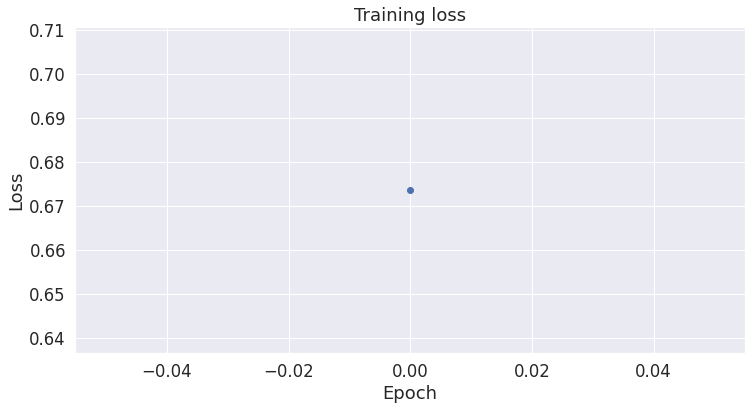

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#5. Saving Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = 'drive/MyDrive/w266: NLP Project/baseline_model/3_day_nl/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to drive/MyDrive/w266: NLP Project/baseline_model/3_day_nl/


('drive/MyDrive/w266: NLP Project/baseline_model/3_day_nl/tokenizer_config.json',
 'drive/MyDrive/w266: NLP Project/baseline_model/3_day_nl/special_tokens_map.json',
 'drive/MyDrive/w266: NLP Project/baseline_model/3_day_nl/vocab.txt',
 'drive/MyDrive/w266: NLP Project/baseline_model/3_day_nl/added_tokens.json')

# 6. Reloading pre-trained model
The code below will allow you to start fresh by reloading a saved model

In [8]:
from keras.preprocessing.sequence import pad_sequences

# !pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report

#set up config
MAX_LEN = 512

#set string to unique file name for saving dfs and AUC images
filenamestring = '72hr_NL_03-24-21_v3'


In [ ]:
#re-load test data if necessary
df_test = pd.read_csv('/content/drive/MyDrive/w266: NLP Project/data/3days_by_hour/test.csv')

# where to look for model
output_dir = '/content/drive/MyDrive/w266: NLP Project/baseline_model/3_day_nl/03-24-21_v3'

# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# 7. Testing Model
The code below runs the test data through the pre-trained readmission model

In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_test.shape[0]))

# Create sentence and label lists
test_ids = df_test['ID']
sentences = df_test['TEXT']
labels = df_test['Label']

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, 
                          maxlen=MAX_LEN, 
                          dtype="long", 
                          truncating="post", 
                          padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels, dtype=torch.long) #ensure we're not passing floats

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 7,256



In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
logit_array , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs= model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
      
      #save logit output from model
      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      # Store predictions and true labels
      logit_array.append(logits)
      true_labels.append(label_ids)
      final_hidden_layer.append(outputs)

print('    DONE.')

Predicting labels for 7,256 test sentences...
    DONE.


In [ ]:
#objects to track outcomes
pred_probs = []
readmit_prob = []

#extract readmit probabilities from logits
for batch in logit_array:
  temp_pred_batch = nn.sigmoid(batch).numpy()
  for pred_arr in temp_pred_batch:
    pred_probs.append(pred_arr)

#extract probability of readmission specifically
for pred_prob in pred_probs:
  readmit_prob.append(pred_prob[1])



In [ ]:
#create empty list to hold "flattened" the predicted labels that the model outputs
pred_labels = []

# For each input batch...
for i in range(len(pred_probs)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest probability and 
  # turn this in to a list of 0s and 1s.  
  single_prediction = np.argmax(pred_probs[i]).flatten()
  pred_labels.append(single_prediction)

#confirm length matches input
len(pred_labels)

7256

In [ ]:
#pull all predictions, labels and IDs into a df for evaluation
# pred_df = pd.DataFrame({"ID":test_ids, 
#                         "true_labels":labels, 
#                         "pred_labels":pred_labels,
#                         "pred_probs": pred_probs,
#                         "readmit_prob": readmit_prob})
# pred_df['ID'] = pred_df['ID'].astype(str)
# pred_df['true_labels'] = pred_df['true_labels'].astype('int64')
# pred_df['pred_labels'] = pred_df['pred_labels'].astype('int64')

# pred_df.to_csv('/content/drive/MyDrive/w266: NLP Project/test_output/'+filenamestring+'_pred_df.csv',index=False )
pred_df = pd.read_csv('/content/drive/MyDrive/w266: NLP Project/test_output/72hr_NL_03-24-21_v3_pred_df.csv')
pred_df.head()


,ID,true_labels,pred_labels,pred_probs,readmit_prob
0,100133.0,1,1,[0.21682511 0.9153336 ],0.915334
1,100133.0,1,1,[0.44277427 0.7698783 ],0.769878
2,100133.0,1,1,[0.08970761 0.9719911 ],0.971991
3,100133.0,1,1,[0.05606877 0.97665274],0.976653
4,100133.0,1,1,[0.05314813 0.9776823 ],0.977682


## 7.1.1 - Experimenting with Voting

Below I run a couple of experiments using the difference (delta) between the logit outputs from the test data. My goal is to see if I can find a way to improve the performance of the voting algorithm.

In [3]:
import ast
import numpy as np
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

pred_df = pd.read_csv('/content/drive/MyDrive/w266: NLP Project/test_output/72hr_NL_03-24-21_v3_pred_df.csv',
                      converters={'pred_probs': from_np_array})
pred_df.head()

,ID,true_labels,pred_labels,pred_probs,readmit_prob
0,100133.0,1,1,"[0.21682511, 0.9153336]",0.915334
1,100133.0,1,1,"[0.44277427, 0.7698783]",0.769878
2,100133.0,1,1,"[0.08970761, 0.9719911]",0.971991
3,100133.0,1,1,"[0.05606877, 0.97665274]",0.976653
4,100133.0,1,1,"[0.05314813, 0.9776823]",0.977682


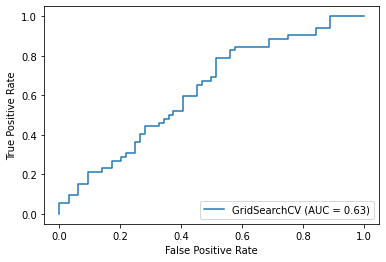

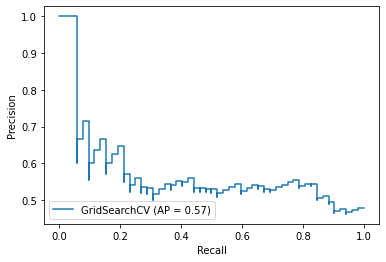

In [ ]:
pred_df_2 = pred_df.copy()
pred_df_2['not_readmit_prob'] = [item[0] for item in pred_df_2['pred_probs']]
pred_df_2['delta'] = pred_df_2['readmit_prob'] - pred_df_2['not_readmit_prob']

#most admission have less than 20 "chunks"
# pred_df_2.groupby('ID')['true_labels'].count().hist(bins=50)

tails = pred_df_2.groupby('ID').head(10)
id_arr = tails['ID'].unique()

test_df = pd.pivot_table(tails, index=['ID'], 
                         columns=tails.groupby(['ID']).cumcount().add(1),values=['delta'],aggfunc='sum')
test_df.columns=test_df.columns.map('{0[0]}{0[1]}'.format) 

admission_label = tails[['ID', 'true_labels']].groupby('ID').agg('mean').reset_index()

from sklearn.impute import KNNImputer, SimpleImputer
imputer = KNNImputer(n_neighbors=3, weights="uniform")
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
test_imp = imputer.fit_transform(test_df)
test_imp_df = pd.DataFrame(test_imp, index = test_df.index).reset_index()
test_imp_df = test_imp_df.merge(admission_label) #merge in labels to be safe

X = test_imp_df.drop(['ID', 'true_labels'], axis = 1)
y = test_imp_df['true_labels']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
# clf = LogisticRegression(random_state=0).fit(X_train, y_train)
grid_values = {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_train, y_train)

# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters
# # First create the base model to 
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

from sklearn import metrics
metrics.plot_roc_curve(grid_clf_acc, X_test, y_test)  
plt.show()  
metrics.plot_precision_recall_curve(grid_clf_acc, X_test, y_test)  
plt.show()  

##7.1 Voting
Reminder that each patient visit may have multiple notes, each note is then broken up into "chunks" that can be fed into the model.  Once the model makes a prediction on a chunk, the chunks need to be re-aggregated through a "voting" process to make the final prediction on whether or not the admission that the chuck was associated with resulted in a re-admission or not.

In [4]:
#sorty - (not sure why they do this) 
df_sort = pred_df.sort_values(by=['ID'])

# #voting - using Huang's technique
temp_pred_agg = (df_sort.groupby(['ID'])['readmit_prob'].agg(max) + 
                 df_sort.groupby(['ID'])['readmit_prob'].agg(sum)/3) / ( 
                     1 + df_sort.groupby(['ID'])['readmit_prob'].agg(len)/3)
                 
label_array = df_sort.groupby(['ID'])['true_labels'].agg(np.min).values #all label values are the same, so min works
df_out = pd.DataFrame({'logits': temp_pred_agg.values, 'label': label_array})
df_out.head()

,logits,label
0,0.803493,1
1,0.559188,0
2,0.684334,0
3,0.554953,1
4,0.373852,1


##7.2 Evaluation
Still need to figure out what's going on with the PR stuff - maybe the model never reaches precision or 80???

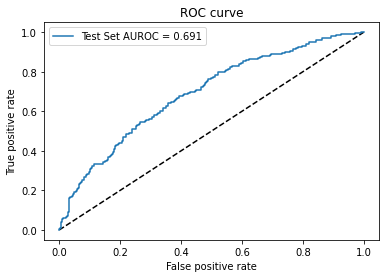

In [10]:
fpr, tpr, thresholds = roc_curve(df_out['label'], df_out['logits'])
auc_score = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Test Set AUROC = {:.3f}'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# plt.show()
plt.savefig('/content/drive/MyDrive/w266: NLP Project/test_output/'+filenamestring+'_AUROC.png')

Recall at Precision of 80 is 0.1793


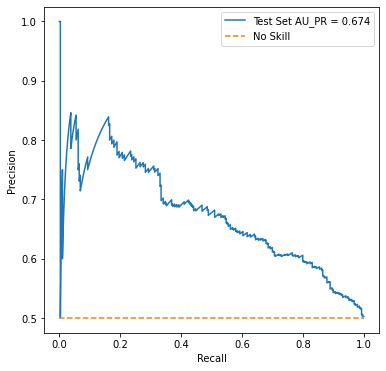

In [11]:
precision, recall, thres = precision_recall_curve(df_out['label'], df_out['logits'])
pr_thres = pd.DataFrame(data =  list(zip(precision, recall, thres)), columns = ['prec','recall','thres'])
auc_score = auc(recall, precision)


#plot PR curve
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall, precision, label='Test Set AU_PR = {:.3f}'.format(auc_score))
noskill = len(df_out[df_out['label']==1]) / len(df_out)
ax.plot([0, 1], [noskill, noskill], linestyle='--', label='No Skill')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='upper right');

fig.savefig('/content/drive/MyDrive/w266: NLP Project/test_output/'+filenamestring+'_PR_curve.png')


temp = pr_thres[pr_thres['prec'] > 0.799999].reset_index()

rp80 = 0
if temp.size == 0:
    print('Test Sample too small or precision never reached .80!')
else:
    rp80 = temp.iloc[0].recall
    print('Recall at Precision of 80 is {:.4f}'.format(rp80))

In [ ]:
|